Here, I have demostrated the usage of bi-directional [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) in performing the sentiment analysis on the Amazon music reviews dataset.

In [1]:
# importing libraries

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [2]:
# loading dataset
df = pd.read_csv('/content/Musical_instruments_reviews.csv')

### EDA

In [3]:
df.shape

(10261, 9)

The dataset has around 10k different entries and 9 different columns. Lets visualize them and see what analysis can be done on the same.

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


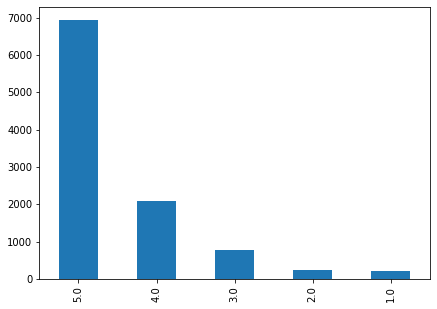

In [5]:
plt.figure(figsize=(7,5))
df.overall.value_counts().plot.bar()
plt.show()

From the above, we note that the distribution of the ratings provided by different users is right skewed. <br>
Creating sentiment column by following rule:<br>
sentiment :   1 if overall>=4.0 <br>

>> 0 otherwise 

In [6]:
df['sentiment'] = df.overall.apply(lambda x : 1 if x>=4 else 0)

We would use `reviewText` and `sentiment` columns for our further processing.

In [7]:
df2 = df[['reviewText', 'sentiment']]

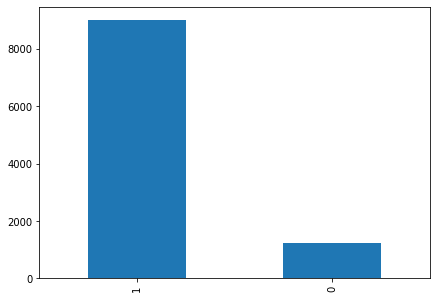

In [8]:
plt.figure(figsize=(7,5))
df2.sentiment.value_counts().plot.bar()
plt.show()

Now out target column is not that skewed distributed and we can performn our model traininng without the fear of class imbalance.

### Text preprocessing

In [9]:
df.reviewText

0        Not much to write about here, but it does exac...
1        The product does exactly as it should and is q...
2        The primary job of this device is to block the...
3        Nice windscreen protects my MXL mic and preven...
4        This pop filter is great. It looks and perform...
                               ...                        
10256              Great, just as expected.  Thank to all.
10257    I've been thinking about trying the Nanoweb st...
10258    I have tried coated strings in the past ( incl...
10259    Well, MADE by Elixir and DEVELOPED with Taylor...
10260    These strings are really quite good, but I wou...
Name: reviewText, Length: 10261, dtype: object

In [10]:
# getting the pandas series into a list
reviews = [i for i in df.reviewText]

1. Tokenize

In [11]:
reviews = [str(rev).lower().split(' ') for rev in reviews]

2. Truncating the reviews to maxlen (i.e. 200)

In [12]:
maxlen = 200
reviews = [rev[:maxlen] for rev in reviews]

3. Encoding the words to numbers. We set the maximum number of feature to max_features (i.e. 10,000).

In [13]:
max_features=10000
reviews = [keras.preprocessing.text.one_hot(' '.join(rev), max_features) for rev in reviews]

4. zero padding the sentences

In [14]:
reviews = [[0]*(maxlen-len(r))+ r[:maxlen] for r in reviews]

5. Sanity check on the length of the inputs

In [15]:
set([len(r) for r in reviews])

{200}

## Train-Validation-Test split 

In [16]:
df2['encoded_rev'] = reviews

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df2.head()

,reviewText,sentiment,encoded_rev
0,"Not much to write about here, but it does exac...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,The product does exactly as it should and is q...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,The primary job of this device is to block the...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Nice windscreen protects my MXL mic and preven...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,This pop filter is great. It looks and perform...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
Train = df2[:int(df2.shape[0]*.9)]

x_train = np.vstack(Train.encoded_rev)
y_train = np.vstack(Train.sentiment)

In [19]:
Val = df2[int(df2.shape[0]*.9) : int(df2.shape[0]*.95)]

x_val = np.vstack(Val.encoded_rev)
y_val = np.vstack(Val.sentiment)

In [20]:
Test = df2[int(df2.shape[0]*.95):]

x_test = np.vstack(Test.encoded_rev)
y_test = np.vstack(Test.sentiment)

## Build the model

In [21]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(200,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
# Add a classifier
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 64)          41216     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,346,113
Trainable params: 1,346,113
Non-train

## Train and evaluate the model


Since our target class is imbalanced, we give class weightage while model tranining so that model do not fit on only one class.

In [22]:
class_weight = {0: len(y_train)/sum(y_train==0), 1: len(y_train)/sum(y_train==1)}


In [23]:
model.compile("adam", "binary_crossentropy", metrics='binary_accuracy')

model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), class_weight=class_weight)

Epoch 1/20
289/289 [==============================] - 25s 48ms/step - loss: 1.2683 - binary_accuracy: 0.6357 - val_loss: 0.6650 - val_binary_accuracy: 0.6140
Epoch 2/20
289/289 [==============================] - 9s 30ms/step - loss: 0.8420 - binary_accuracy: 0.8062 - val_loss: 0.7325 - val_binary_accuracy: 0.6082
Epoch 3/20
289/289 [==============================] - 9s 31ms/step - loss: 0.5289 - binary_accuracy: 0.8874 - val_loss: 0.5738 - val_binary_accuracy: 0.7875
Epoch 4/20
289/289 [==============================] - 9s 31ms/step - loss: 0.2949 - binary_accuracy: 0.9389 - val_loss: 0.6322 - val_binary_accuracy: 0.7622
Epoch 5/20
289/289 [==============================] - 9s 31ms/step - loss: 0.1978 - binary_accuracy: 0.9649 - val_loss: 0.6604 - val_binary_accuracy: 0.8129
Epoch 6/20
289/289 [==============================] - 9s 31ms/step - loss: 0.1537 - binary_accuracy: 0.9715 - val_loss: 0.5917 - val_binary_accuracy: 0.8519
Epoch 7/20
289/289 [==============================] - 9s 

In [24]:
pred = model.predict(x_test)

In [25]:
round_pred = [round(pred[i][0]) for i in range(len(pred))]

In [26]:
y_act = [int(i[0]) for i in y_test]

In [27]:
count = 0
for a,p in zip(y_act, round_pred):
  # print(act, pred)
  if a==p:
    count+=1

print('The obtained model accuracy is %f on the test dataset'%(count/len(y_act)*100))

The obtained model accuracy is 80.155642 on the test dataset


## Conclusion:
From the above, we conclude that we can obtained good performance on the review text features with bi-directional LSTM. Further performance enhancement could be done by tweaking the model's hyperparameters. 
